In [5]:
import os
import re
import sys
import glob
import json
import uproot
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats as st
import scipy

from datetime import datetime

import math
from scipy          import stats
from scipy.optimize import curve_fit

from matplotlib.colors import LogNorm

In [2]:
### Import functions from peak_functions

repository_path = os.path.abspath('/Users/romoluque_c/Repositories/BACON_romo/')
sys.path.append(repository_path)

import blr_functions  as blr
import peak_functions as pf
import fit_functions  as fitf

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
plt.rcParams["figure.figsize"] = 9, 6
plt.rcParams["font.size"]      = 12

In [9]:
evts_path = '/Users/romoluque_c/LEGEND/BACON/new_setup/data_npz_run3/'

trigger_chs = [9, 10, 11]

thr_ADC        = 50
sg_filt_window = 30
min_dist       = 15

def extract_date_and_number(filename):
    match = re.search(r"(\d{2}_\d{2}_\d{4})-file_(\d+)", filename)
    return match.group(1), int(match.group(2))

def adapt_evt_id(evt_id, fnum):
    return 1000000*fnum + np.array(evt_id)

files      = os.listdir(evts_path)
filt_files = sorted(glob.glob(evts_path + f'/BACoN_run3_hits_and_times_thr{thr_ADC}_w{sg_filt_window}_dist{min_dist}_run-*'), key=extract_date_and_number)

In [10]:
filt_evts_all          = {}
idx_peak_thr_all       = {}
h_peak_sg_d_all        = {}
idx_peak_thr_trigg_all = {}
h_peak_sg_d_trigg_all  = {}

normal_chs = range(9)

for filename in filt_files:
    d          = np.load(filename, allow_pickle=True)
    date, fnum = extract_date_and_number(filename)

    if date not in filt_evts_all:
        print(date)
        filt_evts_all   [date] = {ch: d['filt_evts_dict'].item()[ch] for ch in normal_chs}
        idx_peak_thr_all[date] = {ch: np.concatenate(d['idx_peaks_thr_ch_dict']         .item()[ch]) for ch in normal_chs}
        h_peak_sg_d_all [date] = {ch: np.concatenate(d['height_peaks_sg_deconv_ch_dict'].item()[ch]) for ch in normal_chs}

        idx_peak_thr_trigg_all[date] = {ch: np.concatenate(d['idx_peaks_thr_ch_trigg_dict']         .item()[ch]) for ch in trigger_chs}
        h_peak_sg_d_trigg_all [date] = {ch: np.concatenate(d['height_peaks_sg_deconv_ch_trigg_dict'].item()[ch]) for ch in trigger_chs}

                
    for ch in normal_chs:
        try:
            filt_evts_all   [date][ch] = np.concatenate((filt_evts_all   [date][ch], adapt_evt_id(d['filt_evts_dict'].item()[ch], fnum)))
            idx_peak_thr_all[date][ch] = np.concatenate((idx_peak_thr_all[date][ch], np.concatenate(d['idx_peaks_thr_ch_dict']         .item()[ch])))
            h_peak_sg_d_all [date][ch] = np.concatenate((h_peak_sg_d_all [date][ch], np.concatenate(d['height_peaks_sg_deconv_ch_dict'].item()[ch])))
        
        except Exception as e:
            print(date, fnum, filename, ch, str(e))
            continue

    for ch in trigger_chs:
        idx_peak_thr_trigg_all[date][ch] = np.concatenate((idx_peak_thr_trigg_all[date][ch], np.concatenate(d['idx_peaks_thr_ch_trigg_dict']         .item()[ch])))
        h_peak_sg_d_trigg_all [date][ch] = np.concatenate((h_peak_sg_d_trigg_all [date][ch], np.concatenate(d['height_peaks_sg_deconv_ch_trigg_dict'].item()[ch])))

09_08_2024
09_09_2024
09_10_2024
09_11_2024
09_12_2024
09_20_2024
09_25_2024
09_28_2024
10_04_2024
10_04_2024 79 /Users/romoluque_c/LEGEND/BACON/new_setup/data_npz_run3/BACoN_run3_hits_and_times_thr50_w30_dist15_run-10_04_2024-file_79.npz 4 need at least one array to concatenate
10_11_2024
10_17_2024


## Channels 0 - 8

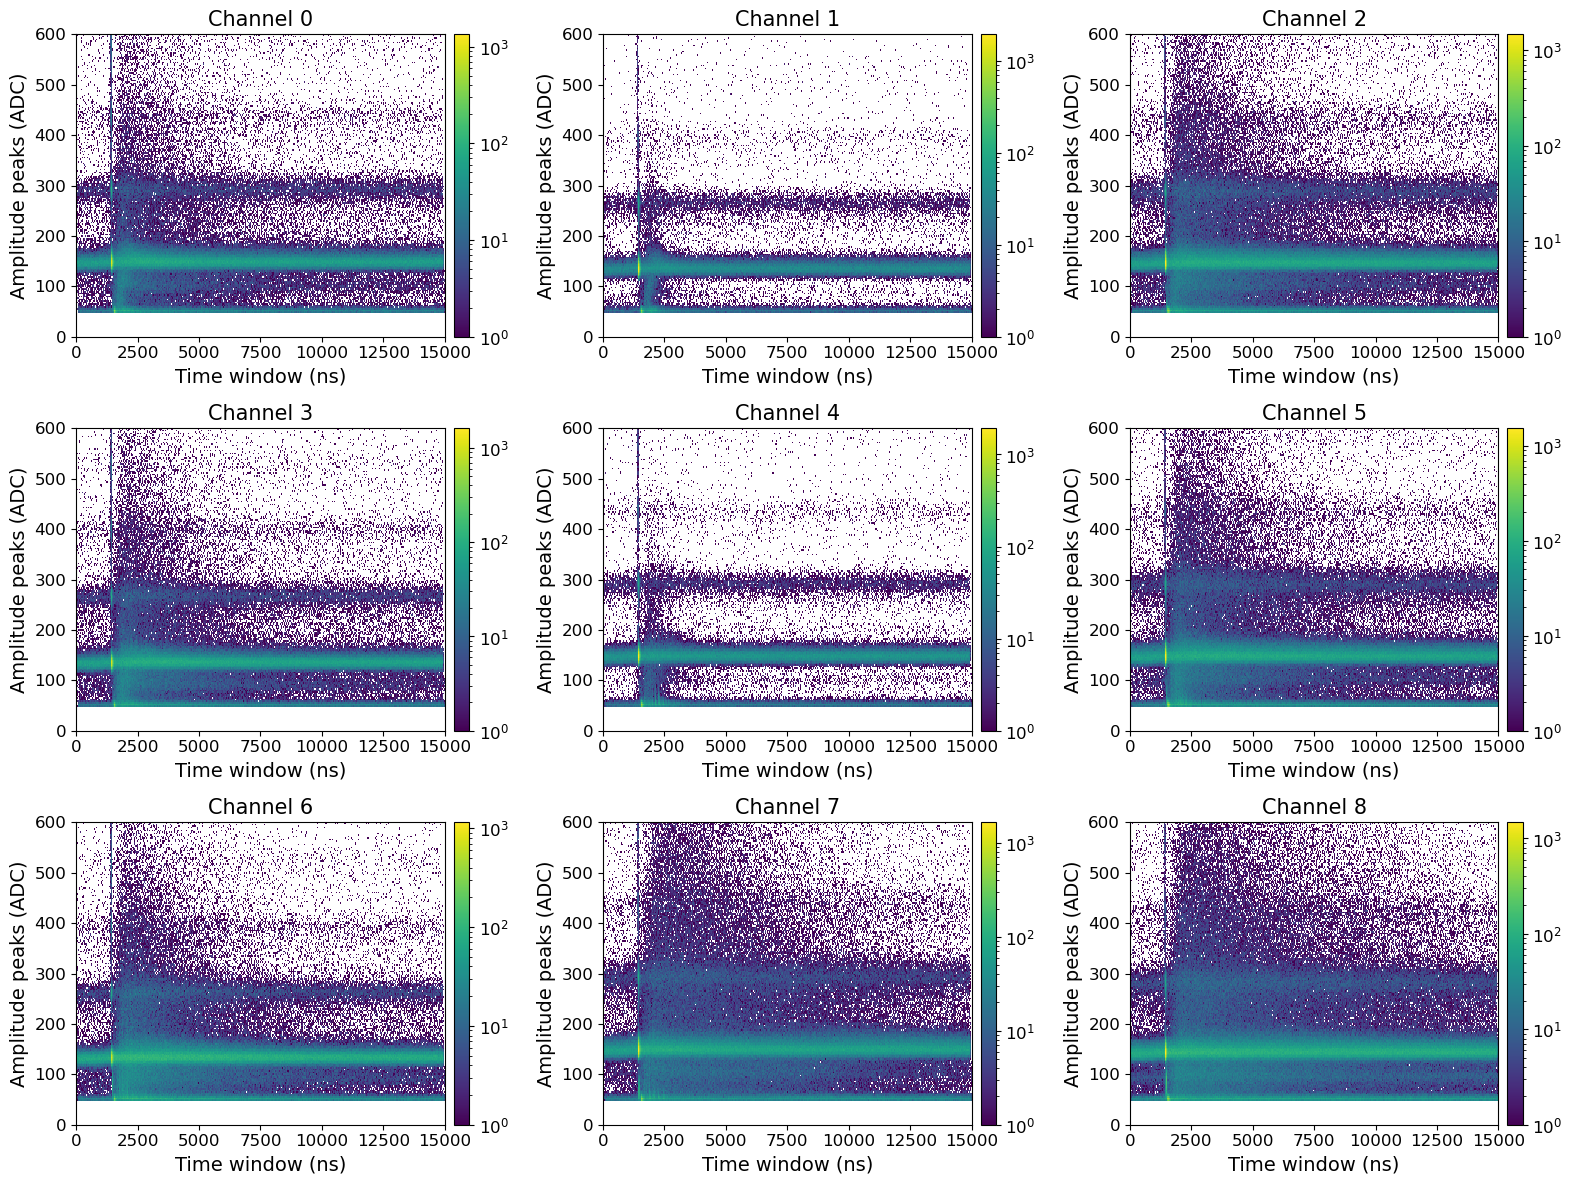

In [11]:
fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in normal_chs:
    i = int(k/3)
    j = k%3
    
    ch_idxs = np.concatenate(([idx_peak_thr_all[date][k] for date in idx_peak_thr_all.keys()]))
    ch_vals = np.concatenate(([h_peak_sg_d_all [date][k] for date in idx_peak_thr_all.keys()]))
    
    fig0 = axs[i][j].hist2d(ch_idxs*2, ch_vals, bins=(500, 200), range=((0, 15000), (0, 600)), cmin=1, norm=LogNorm())
    axs[i][j].set_xlabel('Time window (ns)',     fontsize=14)
    axs[i][j].set_ylabel('Amplitude peaks (ADC)', fontsize=14)
    axs[i][j].set_title(f"Channel {k}",          fontsize=15)
    fig.colorbar(fig0[3], ax=axs[i][j], pad=0.02)
plt.tight_layout()
plt.show()

## Trigger SiPMs

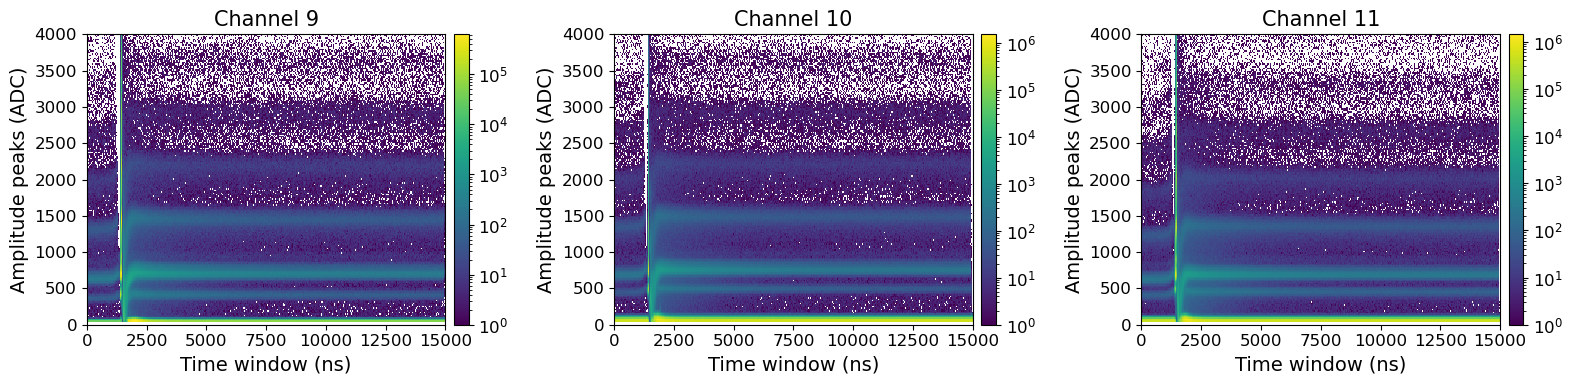

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for k in [9, 10, 11]:
    j = k%3

    ch_idxs = np.concatenate(([idx_peak_thr_trigg_all[date][k] for date in idx_peak_thr_trigg_all.keys()]))
    ch_vals = np.concatenate(([h_peak_sg_d_trigg_all [date][k] for date in idx_peak_thr_trigg_all.keys()]))
    
    fig0 = axs[j].hist2d(ch_idxs*2, ch_vals, bins=(500, 200), range=((0, 15000), (0, 4000)), cmin=1, norm=LogNorm())
    axs[j].set_xlabel('Time window (ns)',      fontsize=14)
    axs[j].set_ylabel('Amplitude peaks (ADC)', fontsize=14)
    axs[j].set_title(f"Channel {k}",           fontsize=15)
    fig.colorbar(fig0[3], ax=axs[j], pad=0.02)
plt.tight_layout()
plt.show()

## Remove hits with high light levels:

In [14]:
idx_peak_thr_pretrigg_and_hl_cut       = {}
h_peak_sg_d_pretrigg_and_hl_cut        = {}
num_evts_ch_pretrigg_and_hl_cut        = {}
idx_peak_thr_trigg_pretrigg_and_hl_cut = {}
h_peak_sg_d_trigg_pretrigg_and_hl_cut  = {}
num_evts_ch_trigg_pretrigg_and_hl_cut  = {}

print(len(filt_files))
for ifile,filename in enumerate(filt_files):
    if ifile%20==0:
        print(ifile)
    d          = np.load(filename, allow_pickle=True)
    date, fnum = extract_date_and_number(filename)

    #print(date, fnum)
    for ch in normal_chs:
        idx_peaks_ch_after_cut    = []
        height_peaks_ch_after_cut = []
        num_evts                  = 0
        idx_peaks_ch    = d['idx_peaks_thr_ch_dict']         .item()[ch]
        height_peaks_ch = d['height_peaks_sg_deconv_ch_dict'].item()[ch]
        for idxs, vals in zip(idx_peaks_ch, height_peaks_ch):
            if len(idxs)==0:
                continue
            elif np.any(np.array(idxs) < 650):
                continue
            elif np.any(np.array(vals) > 500):
                continue
            else:
                idx_peaks_ch_after_cut   .append(idxs)
                height_peaks_ch_after_cut.append(vals)
                num_evts += 1
                
        if date not in idx_peak_thr_pretrigg_and_hl_cut:
            print(date)
            idx_peak_thr_pretrigg_and_hl_cut[date] = {}
            h_peak_sg_d_pretrigg_and_hl_cut [date] = {}
            num_evts_ch_pretrigg_and_hl_cut [date] = {}

        if ch not in idx_peak_thr_pretrigg_and_hl_cut[date]:
            try:
                idx_peak_thr_pretrigg_and_hl_cut[date][ch] = np.concatenate(idx_peaks_ch_after_cut)
                h_peak_sg_d_pretrigg_and_hl_cut [date][ch] = np.concatenate(height_peaks_ch_after_cut)
                num_evts_ch_pretrigg_and_hl_cut [date][ch] = np.array([num_evts])
            except Exception as e:
                print(e)
                continue
        else:
            try:
                idx_peak_thr_pretrigg_and_hl_cut[date][ch] = np.concatenate((idx_peak_thr_pretrigg_and_hl_cut[date][ch], np.concatenate(idx_peaks_ch_after_cut)))
                h_peak_sg_d_pretrigg_and_hl_cut [date][ch] = np.concatenate((h_peak_sg_d_pretrigg_and_hl_cut [date][ch], np.concatenate(height_peaks_ch_after_cut)))
                num_evts_ch_pretrigg_and_hl_cut [date][ch] = np.concatenate((num_evts_ch_pretrigg_and_hl_cut [date][ch], np.array([num_evts])))
            except Exception as e:
                print(e)
                continue
        
        
    for ch in trigger_chs:
        idx_peaks_ch_after_cut    = []
        height_peaks_ch_after_cut = []
        num_evts                  = 0
        idx_peaks_ch    = d['idx_peaks_thr_ch_trigg_dict']         .item()[ch]
        height_peaks_ch = d['height_peaks_sg_deconv_ch_trigg_dict'].item()[ch]
        for idxs, vals in zip(idx_peaks_ch, height_peaks_ch):
            if len(idxs)==0:
                continue
            elif np.any(np.array(idxs) < 650):
                continue
            else:
                idx_peaks_ch_after_cut   .append(idxs)
                height_peaks_ch_after_cut.append(vals)
                num_evts += 1
                
        if date not in idx_peak_thr_trigg_pretrigg_and_hl_cut:
            idx_peak_thr_trigg_pretrigg_and_hl_cut[date] = {}
            h_peak_sg_d_trigg_pretrigg_and_hl_cut [date] = {}
            num_evts_ch_trigg_pretrigg_and_hl_cut [date] = {}
    
        if ch not in idx_peak_thr_trigg_pretrigg_and_hl_cut[date]:
            try:
                idx_peak_thr_trigg_pretrigg_and_hl_cut[date][ch] = np.concatenate(idx_peaks_ch_after_cut)
                h_peak_sg_d_trigg_pretrigg_and_hl_cut [date][ch] = np.concatenate(height_peaks_ch_after_cut)
                num_evts_ch_trigg_pretrigg_and_hl_cut [date][ch] = np.array([num_evts])
            except Exception as e:
                print(e)
                continue
        else:
            try:
                idx_peak_thr_trigg_pretrigg_and_hl_cut[date][ch] = np.concatenate((idx_peak_thr_trigg_pretrigg_and_hl_cut[date][ch], np.concatenate(idx_peaks_ch_after_cut)))
                h_peak_sg_d_trigg_pretrigg_and_hl_cut [date][ch] = np.concatenate((h_peak_sg_d_trigg_pretrigg_and_hl_cut [date][ch], np.concatenate(height_peaks_ch_after_cut)))
                num_evts_ch_trigg_pretrigg_and_hl_cut [date][ch] = np.concatenate((num_evts_ch_trigg_pretrigg_and_hl_cut [date][ch], np.array([num_evts])))
            except Exception as e:
                print(e)
                continue

648
0
09_08_2024
20
40
09_09_2024
60
80
09_10_2024
100
09_11_2024
120
09_12_2024
140
09_20_2024
160
180
200
220
240
09_25_2024
260
280
300
09_28_2024
320
340
360
10_04_2024
380
400
420
440
need at least one array to concatenate
10_11_2024
460
480
500
520
540
10_17_2024
560
580
600
620
640


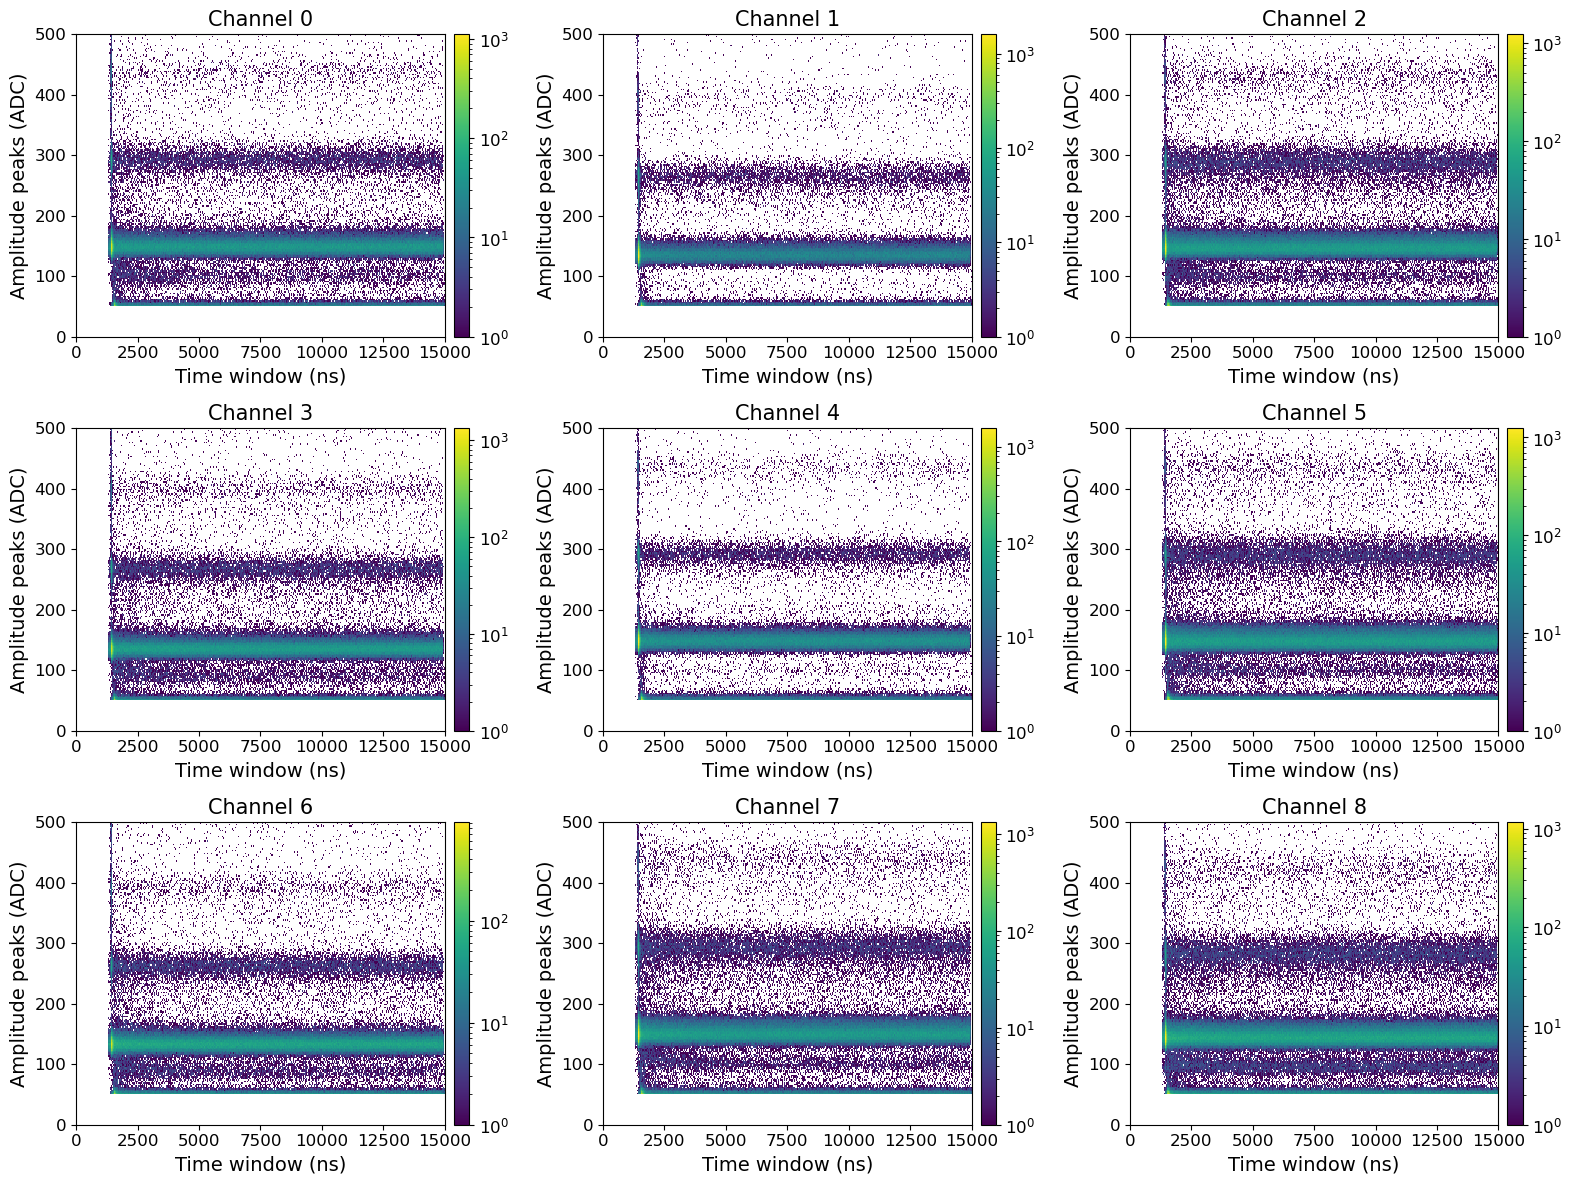

In [18]:
sel_dates = idx_peak_thr_pretrigg_and_hl_cut.keys()
fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in normal_chs:
    i = int(k/3)
    j = k%3
    
    try:
        ch_idxs = np.concatenate([idx_peak_thr_pretrigg_and_hl_cut[date][k] for date in sel_dates])
        ch_vals = np.concatenate([h_peak_sg_d_pretrigg_and_hl_cut [date][k] for date in sel_dates])
    
        fig0 = axs[i][j].hist2d(ch_idxs*2, ch_vals, bins=(500, 200), range=((0, 15000), (0, 500)), cmin=1, norm=LogNorm())
        axs[i][j].set_xlabel('Time window (ns)',     fontsize=14)
        axs[i][j].set_ylabel('Amplitude peaks (ADC)', fontsize=14)
        axs[i][j].set_title(f"Channel {k}",          fontsize=15)
        fig.colorbar(fig0[3], ax=axs[i][j], pad=0.02)
    except Exception as e:
        print(e)
        continue
plt.tight_layout()
#plt.savefig('/global/homes/r/romo/BACoN_analysis/Run3/plots/run3_hits_and_times_pretrigger_cut2_500ADC.png', dpi=300, bbox_inches='tight')
plt.show()

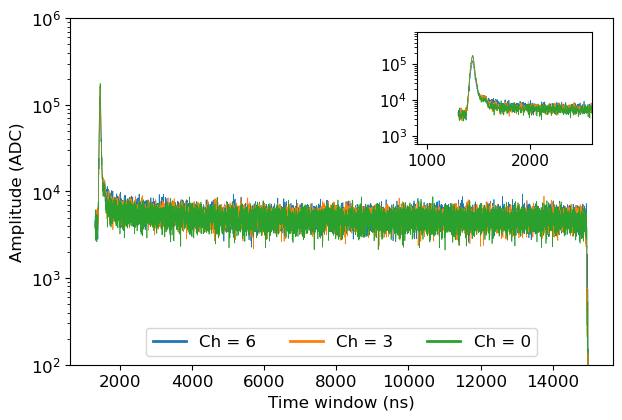

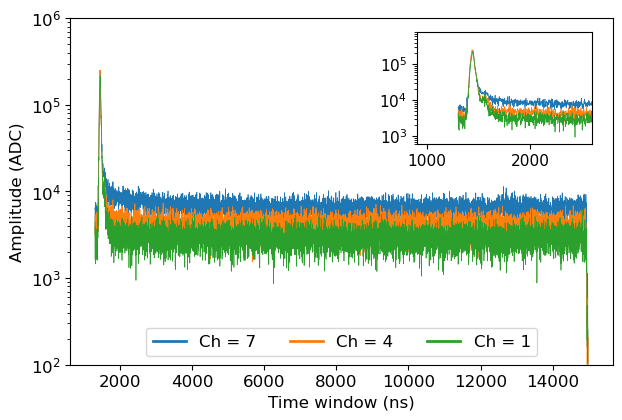

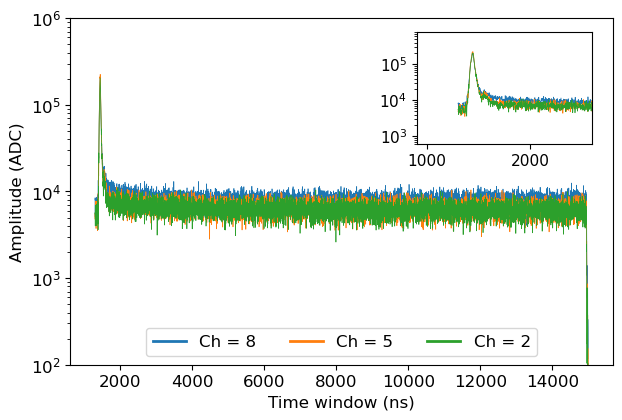

In [22]:
for sel_chs in [[6, 3, 0], [7, 4, 1], [8, 5, 2]]:
    fig = plt.figure(figsize=(7, 4.5))
    for ch in sel_chs:
        timestamps = 2*np.concatenate([idx_peak_thr_pretrigg_and_hl_cut[date][ch] for date in idx_peak_thr_pretrigg_and_hl_cut.keys()])
        amplitudes =   np.concatenate([h_peak_sg_d_pretrigg_and_hl_cut [date][ch] for date in idx_peak_thr_pretrigg_and_hl_cut.keys()])
        
        unique_timestamps = np.unique(timestamps)
        sum_amplitudes    = [np.sum(amplitudes[timestamps == timestamp]) for timestamp in unique_timestamps]
    
        plt.plot(unique_timestamps, sum_amplitudes, lw=0.5, label=f'Ch = {ch}')
        

    plt.xlabel('Time window (ns)', fontsize=12)
    plt.ylabel('Amplitude (ADC)',   fontsize=12)
    plt.yscale('log')
    plt.ylim(1e2, 1e6)
    leg = plt.legend(loc='lower center', ncol=3)
    for line in leg.get_lines():
        line.set_linewidth(2)
        
    ax_inset = fig.add_axes([0.62, 0.60, 0.25, 0.25])
    for ch in sel_chs:
        timestamps = 2*np.concatenate([idx_peak_thr_pretrigg_and_hl_cut[date][ch] for date in idx_peak_thr_pretrigg_and_hl_cut.keys()])
        amplitudes =   np.concatenate([h_peak_sg_d_pretrigg_and_hl_cut [date][ch] for date in idx_peak_thr_pretrigg_and_hl_cut.keys()])
        
        unique_timestamps = np.unique(timestamps)
        sum_amplitudes    = [np.sum(amplitudes[timestamps == timestamp]) for timestamp in unique_timestamps]
    
        ax_inset.plot(unique_timestamps, sum_amplitudes, lw=0.5)
        
        
    ax_inset.set_xlim(900, 2600)
    ax_inset.set_ylim(6e2, 8e5)
    ax_inset.tick_params(axis='x', labelsize=11)
    ax_inset.tick_params(axis='y', labelsize=11)
    ax_inset.set_yscale('log')
    #plt.savefig(f'/global/homes/r/romo/BACoN_analysis/Run3/plots/run3_hits_and_times_summed_pretrigger_cut2_500ADC_zoom_chs_{sel_chs[0]}_{sel_chs[1]}_{sel_chs[2]}.png', dpi=300, bbox_inches='tight')
    plt.show()

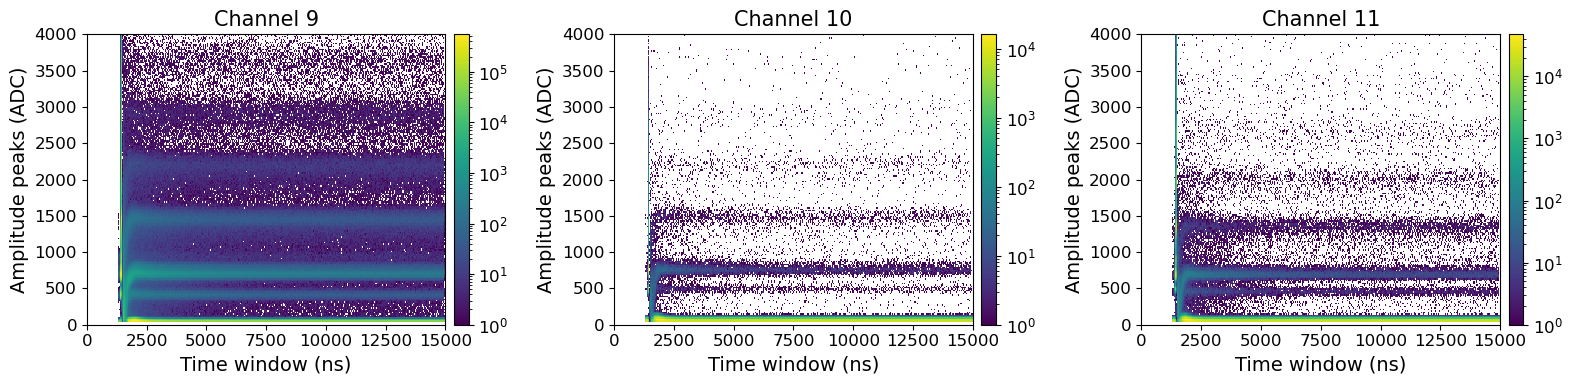

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for k in [9, 10, 11]:
    j = k%3

    ch_idxs = np.concatenate(([idx_peak_thr_trigg_pretrigg_and_hl_cut[date][k] for date in idx_peak_thr_trigg_pretrigg_and_hl_cut.keys()]))
    ch_vals = np.concatenate(([h_peak_sg_d_trigg_pretrigg_and_hl_cut [date][k] for date in idx_peak_thr_trigg_pretrigg_and_hl_cut.keys()]))
    
    fig0 = axs[j].hist2d(ch_idxs*2, ch_vals, bins=(500, 200), range=((0, 15000), (0, 4000)), cmin=1, norm=LogNorm())
    axs[j].set_xlabel('Time window (ns)',      fontsize=14)
    axs[j].set_ylabel('Amplitude peaks (ADC)', fontsize=14)
    axs[j].set_title(f"Channel {k}",           fontsize=15)
    fig.colorbar(fig0[3], ax=axs[j], pad=0.02)
plt.tight_layout()
#plt.savefig('/global/homes/r/romo/BACoN_analysis/Run3/plots/run3_hits_and_times_trigg_chs_pretrigger_cut2.png', dpi=300, bbox_inches='tight')
plt.show()